In [192]:
import numpy as np
import pandas as pd

import shutil, random, os
import tensorflow as tf
import tensorboard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

import re

In [14]:
!mkdir -p train/{neg,pos}; mkdir -p val/{neg,pos}

In [2]:
dir_1 = 'FrameFilter-set1_4k/'
dir_2 = 'FrameFilter-set2_fifawc2018/'
dir_3 = 'FrameFilter-set3_fhd/'
train_dir = 'train/'
val_dir = 'val/'

In [16]:
# positive samples
for directory in (dir_1, dir_2, dir_3):
    path = os.path.join(directory, 'pos')
    num_samples = len(os.listdir(path))
    print(path, num_samples)
    train_dest = 'train/pos'
    val_dest = 'val/pos'
    num_train_samples = int(0.8*num_samples)
    train_samples = random.sample(os.listdir(path), num_train_samples)
    
    for sample in train_samples:
        source_path = os.path.join(path, sample)
        dest_path = os.path.join(train_dest, sample)
        shutil.move(source_path, dest_path)
    print(len(os.listdir(train_dest)))
    
    val_samples = os.listdir(path)
    for sample in val_samples:
        source_path = os.path.join(path, sample)
        dest_path = os.path.join(val_dest, sample)
        shutil.move(source_path, dest_path)
    print(len(os.listdir(val_dest)))


FrameFilter-set1_4k/pos 417
333
84
FrameFilter-set2_fifawc2018/pos 475
713
179
FrameFilter-set3_fhd/pos 751
1313
330


In [17]:
# negative samples
for directory in (dir_1, dir_2, dir_3):
    path = os.path.join(directory, 'neg')
    num_samples = len(os.listdir(path))
    print(path, num_samples)
    train_dest = 'train/neg'
    val_dest = 'val/neg'
    num_train_samples = int(0.8*num_samples)
    train_samples = random.sample(os.listdir(path), num_train_samples)
    
    for sample in train_samples:
        source_path = os.path.join(path, sample)
        dest_path = os.path.join(train_dest, sample)
        shutil.move(source_path, dest_path)
    print(len(os.listdir(train_dest)))
    
    val_samples = os.listdir(path)
    for sample in val_samples:
        source_path = os.path.join(path, sample)
        dest_path = os.path.join(val_dest, sample)
        shutil.move(source_path, dest_path)
    print(len(os.listdir(val_dest)))


FrameFilter-set1_4k/neg 482
385
97
FrameFilter-set2_fifawc2018/neg 348
663
167
FrameFilter-set3_fhd/neg 505
1067
268


In [3]:
img_width, img_height = 224, 224

In [57]:
# semi-LeNet baseline
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5,5), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1023 (Conv2D)         (None, 220, 220, 6)       456       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_1024 (Conv2D)         (None, 106, 106, 16)      2416      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               5393400   
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

In [61]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="results/basic", 
                                        monitor="val_loss", 
                                        save_best_only=True, 
                                        verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='basic/log')

In [62]:
# no augmentation
batch_size = 20
epochs = 100

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2380 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


In [63]:
nb_train_samples = train_generator.n
nb_val_samples = validation_generator.n

history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(nb_train_samples / batch_size),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=np.ceil(nb_val_samples / batch_size),
      callbacks=[checkpointer, tensorboard, early_stopping],
      verbose=1)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9958
Epoch 00001: val_loss improved from inf to 0.12197, saving model to results/basic
INFO:tensorflow:Assets written to: results/basic/assets
119/119 [==============================] - 172s 1s/step - loss: 0.0173 - accuracy: 0.9958 - val_loss: 0.1220 - val_accuracy: 0.9599
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9971
Epoch 00002: val_loss did not improve from 0.12197
119/119 [==============================] - 171s 1s/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 0.1448 - val_accuracy: 0.9565
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9916
Epoch 00003: val_loss did not improve from 0.12197
119/119 [==============================] - 171s 1s/step - loss: 0.0203 - accuracy: 0.9916 - val_loss: 0.1810 - val_accuracy: 0.9565
Epoch 4/100
119/119 [==============================] - ETA: 0s - loss: 0.

In [80]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [83]:
np.around(Y_pred, decimals=0)

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],

<AxesSubplot:>

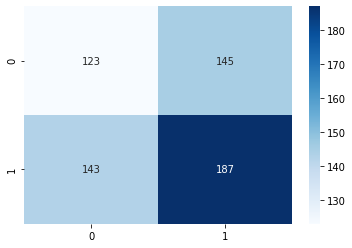

In [78]:
Y_pred = model.predict(validation_generator)
y_pred = np.rint(Y_pred)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')

In [71]:
basic_results = model.evaluate(validation_generator)
print(f"Loss and accuracy: {basic_results}")

30/30 [==============================] - 33s 1s/step - loss: 0.1742 - accuracy: 0.9732
Loss and accuracy: [0.174179807305336, 0.9732441306114197]


In [84]:
# InceptionResNet_V2 with no augmentation
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2380 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


In [85]:
base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        pooling="avg",
        weights="imagenet",
        input_shape=(img_width, img_height, 3)
        )

output = base_model.output
output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
    
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1025 (Conv2D)            (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1015 (Batch (None, 111, 111, 32) 96          conv2d_1025[0][0]                
__________________________________________________________________________________________________
activation_1015 (Activation)    (None, 111, 111, 32) 0           batch_normalization_1015[0][0]   
____________________________________________________________________________________________

block17_13_mixed (Concatenate)  (None, 12, 12, 384)  0           activation_1139[0][0]            
                                                                 activation_1142[0][0]            
__________________________________________________________________________________________________
block17_13_conv (Conv2D)        (None, 12, 12, 1088) 418880      block17_13_mixed[0][0]           
__________________________________________________________________________________________________
block17_13 (Lambda)             (None, 12, 12, 1088) 0           block17_12_ac[0][0]              
                                                                 block17_13_conv[0][0]            
__________________________________________________________________________________________________
block17_13_ac (Activation)      (None, 12, 12, 1088) 0           block17_13[0][0]                 
__________________________________________________________________________________________________
conv2d_115

In [86]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="results/inception", 
                                        monitor="val_loss", 
                                        save_best_only=True, 
                                        verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='inception/log')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

In [87]:
history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(nb_train_samples / batch_size),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=np.ceil(nb_val_samples / batch_size),
      callbacks=[checkpointer, tensorboard, early_stopping],
      verbose=1)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9622
Epoch 00001: val_loss improved from inf to 3.14997, saving model to results/inception
INFO:tensorflow:Assets written to: results/inception/assets
119/119 [==============================] - 274s 2s/step - loss: 0.1399 - accuracy: 0.9622 - val_loss: 3.1500 - val_accuracy: 0.4532
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9870
Epoch 00002: val_loss improved from 3.14997 to 0.04152, saving model to results/inception
INFO:tensorflow:Assets written to: results/inception/assets
119/119 [==============================] - 267s 2s/step - loss: 0.0619 - accuracy: 0.9870 - val_loss: 0.0415 - val_accuracy: 0.9900
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9895
Epoch 00003: val_loss did not improve from 0.04152
119/119 [==============================] - 171s 1s/step - loss: 0.0414 - accuracy: 0.9895 - val_lo

In [88]:
inception_results = model.evaluate(validation_generator)
print(f"Loss and accuracy: {inception_results}")

30/30 [==============================] - 33s 1s/step - loss: 0.0932 - accuracy: 0.9716
Loss and accuracy: [0.09320807456970215, 0.9715719223022461]


<AxesSubplot:>

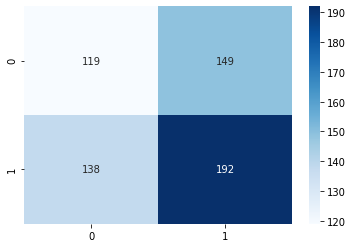

In [89]:
Y_pred = model.predict(validation_generator)
y_pred = np.rint(Y_pred)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')

In [103]:
# InceptionResNet_V2 with augmentation
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
                                   zoom_range=[0.5, 1.5], 
                                   horizontal_flip=True, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   fill_mode='reflect', 
                                   shear_range=0.01, 
                                   brightness_range=[0.5, 1.5])

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height), 
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2380 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


In [91]:
base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        pooling="avg",
        weights="imagenet",
        input_shape=(img_width, img_height, 3)
        )

output = base_model.output
output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
    
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1228 (Conv2D)            (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1218 (Batch (None, 111, 111, 32) 96          conv2d_1228[0][0]                
__________________________________________________________________________________________________
activation_1218 (Activation)    (None, 111, 111, 32) 0           batch_normalization_1218[0][0]   
____________________________________________________________________________________________

block17_11_conv (Conv2D)        (None, 12, 12, 1088) 418880      block17_11_mixed[0][0]           
__________________________________________________________________________________________________
block17_11 (Lambda)             (None, 12, 12, 1088) 0           block17_10_ac[0][0]              
                                                                 block17_11_conv[0][0]            
__________________________________________________________________________________________________
block17_11_ac (Activation)      (None, 12, 12, 1088) 0           block17_11[0][0]                 
__________________________________________________________________________________________________
conv2d_1349 (Conv2D)            (None, 12, 12, 128)  139264      block17_11_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_1339 (Batch (None, 12, 12, 128)  384         conv2d_1349[0][0]                
__________

In [92]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="results/augmented_inception", 
                                        monitor="val_loss", 
                                        save_best_only=True, 
                                        verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='augmented_inception/log')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

In [93]:
history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(nb_train_samples / batch_size),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=np.ceil(nb_val_samples / batch_size),
      callbacks=[checkpointer, tensorboard, early_stopping],
      verbose=1)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9450
Epoch 00001: val_loss improved from inf to 0.07883, saving model to results/augmented_inception
INFO:tensorflow:Assets written to: results/augmented_inception/assets
119/119 [==============================] - 293s 2s/step - loss: 0.1859 - accuracy: 0.9450 - val_loss: 0.0788 - val_accuracy: 0.9666
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9765
Epoch 00002: val_loss did not improve from 0.07883
119/119 [==============================] - 196s 2s/step - loss: 0.0962 - accuracy: 0.9765 - val_loss: 0.2628 - val_accuracy: 0.9047
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9706
Epoch 00003: val_loss improved from 0.07883 to 0.04266, saving model to results/augmented_inception
INFO:tensorflow:Assets written to: results/augmented_inception/assets
119/119 [==============================] - 291s 2s/step - 

In [94]:
inception_results = model.evaluate(validation_generator)
print(f"Loss and accuracy: {inception_results}")

30/30 [==============================] - 32s 1s/step - loss: 0.0610 - accuracy: 0.9833
Loss and accuracy: [0.061030786484479904, 0.9832776188850403]


<AxesSubplot:>

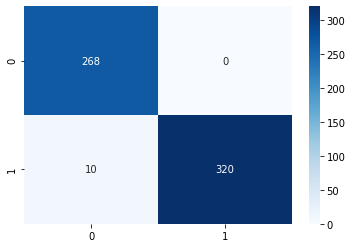

In [104]:
Y_pred = model.predict(validation_generator)
pred_bool = (Y_pred>=0.5)
y_pred = pred_bool.astype(int)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')

Best results gave Inception ResNet V2:

    - 75% lower loss than basic semi-LeNet model
    
    - 46% lower loss than Inception Reset V2 without augmentation

In [117]:
! mkdir 'test'
! mv 'FrameFilter-test_set/' 'test/FrameFilter-test_set/'

In [118]:
test_dir = 'test/'

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

test_generator =  test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        )

Found 600 images belonging to 1 classes.


In [154]:
nb_test_samples = test_generator.n
test_pred = model.predict(test_generator, verbose=1)

30/30 [==============================] - 13s 448ms/step


In [155]:
test_pred = np.round(test_pred, decimals=3)

In [158]:
file_names = np.copy(test_generator.filenames)

In [173]:
test_pred = np.reshape(test_pred, (600,1))

In [186]:
pattern = '[\w-]+\.jpg'
i = 0
for string in file_names:
    name = re.findall(pattern, string[0])
    file_names[i][0] = name[0]
    i += 1

In [188]:
file_names = np.reshape(file_names, (600,1))

In [189]:
test_results = np.concatenate((file_names, test_pred), axis=1)

In [197]:
pd.DataFrame(test_results, columns=['name', 'probability'])

,name,probability
0,000000-f6f091083fcc5948725ef21f-11-2250-22050.jpg,0.982
1,000001-c371eab259dd483bd58c25d8-13-1000-24400.jpg,0.998
2,000002-540208e670abd2b2613b8dfa-39-2750-72950.jpg,1.0
3,000003-16f99beaf8446ba44a25e1f6-14-500-25700.jpg,0.999
4,000004-0df26117d1a490e48873f39d-26-4250-51050.jpg,0.958
...,...,...
595,000595-74428a96af9c647fc5385782-29-4750-56950.jpg,0.0
596,000596-188b991a3c295dc93f80412c-10-1250-19250.jpg,0.001
597,000597-3e9c014a4c93d2250ff0e7c1-10-2250-20250.jpg,0.0
598,000598-54214f4c1bb874fa206c2e02-1-3500-5300.jpg,0.0


In [198]:
df = pd.DataFrame(test_results, columns=['name', 'probability'])
df.to_csv('results.csv', index=False)

key aspects:

    - choose right model architecture
    - make some basics experiments to compare
    - try suitable augmentation (real-like)
    - evaluate model, check and compare metrics
    - try confussion matrix to see what kind of bias we can have
    - extra: decice if that bias is ok, change parameters, architecture, augmenttion due to needs